In [1]:
import numpy as np
import sys

sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

import math
from tqdm import tqdm
from copy import deepcopy

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators
from GGH.models import initialize_model, Autoencoder
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, plot_histogram, visualize_train_val_error, selection_histograms, create_heatmap, cluster_and_visualize, \
                          get_gradarrays_n_labels, prep_tsne_min_max_ranges, sep_grads_by_labels, plot_confusion_matrix, \
                          extract_elements

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, precision_score, balanced_accuracy_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

def full_info_run_existing_DO(DO, do_df_train_noisy, r_state, num_epochs = 300):
    use_info = "full info"
    num_epochs = num_epochs
    r_state = r_state
    AM = AlgoModulators(DO, lr = 0.001)
    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, pre_defined_train = do_df_train_noisy, device = "cpu")
    dataloader = DO.prep_dataloader(use_info, batch_size)    
    model = initialize_model(DO, dataloader, hidden_size, r_state, dropout = 0.05) 
    TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, r_state, results_path, select_gradients = select_gradients, best_valid_error = np.inf)
    TVM.train_model(DO, AM, model, final_analysis = True)
    
    return DO, TVM, AM, model


#User requiered data and parameters
data_path = '../data/photoredox_yield/photo_redox_merck2021_1649reactions.csv'
results_path = "../saved_results/Photoredox Yield"
inpt_vars = ['aryl_halides', 'photocalysts', 'piperidines_moles','photocalysts_moles']
target_vars = ['uplcms']

miss_vars = []
hypothesis = [[0.02, 0.05, 0.50, 5.0]]

#Percentage of simulated data with full information
partial_perc = 0.3
rand_state = 42

#Model Train Parameters
hidden_size = 32
batch_size = 100*len(hypothesis[0])
output_size = len(target_vars)

##################
#IMPORTANT VARIABLES TO DETERMINE EXPERIMENT TYPE
##################
DATA_NOISE_PERC = 0.3  #How much data will have noise
NOISE_MAXRANGE  = 0.6 #The range around the mean 
NOISE_MINRANGE  = 0.4 
noise_profile = {"DATA_NOISE_PERC":DATA_NOISE_PERC, "NOISE_MINRANGE":NOISE_MINRANGE, "NOISE_MAXRANGE":NOISE_MAXRANGE}

num_epochs = 300
#Should break train data into even parts for DBSCAN
batch_size = 299
gradwcontext = True #having the loss value helps
select_gradients = True

use_info = "known info noisy simulation"

INSPECT = Inspector(results_path, hidden_size)
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu", use_case = "noise detection")
DO.simulate_noise(DATA_NOISE_PERC, NOISE_MINRANGE, NOISE_MAXRANGE)
#DO.df_train_noisy[target_vars[0]].hist()

AM = AlgoModulators(DO, lr = 0.001)

In [23]:
#%%capture
total_runs = 15
use_info ="full info noisy"
num_epochs = 300
progress_bar = tqdm(total=total_runs)
for r_state in range(total_runs): #

    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu", use_case = "noise detection")
    DO.simulate_noise(DATA_NOISE_PERC, NOISE_MINRANGE, NOISE_MAXRANGE)
    dataloader = DO.prep_dataloader(use_info, batch_size)    
    model = initialize_model(DO, dataloader, hidden_size, r_state, dropout = 0.05) 
    TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, r_state, results_path, select_gradients = select_gradients, final_analysis = True)
    TVM.train_model(DO, AM, model, final_analysis = True)
    INSPECT.save_train_val_logs(DO, AM, TVM, model, final_analysis = True, noise_profile = noise_profile)
    progress_bar.update(1)
    if progress_bar.n == total_runs:
        break       
progress_bar.close()

100%|██████████| 15/15 [00:52<00:00,  3.47s/it]


In [24]:
#%%capture
total_runs = 15
use_info ="full info"
num_epochs = 500
progress_bar = tqdm(total=total_runs)
for r_state in range(total_runs): #

    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu", use_case = "noise detection")
    dataloader = DO.prep_dataloader(use_info, batch_size)    
    model = initialize_model(DO, dataloader, hidden_size, r_state, dropout = 0.05) 
    TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, r_state, results_path, select_gradients = select_gradients, final_analysis = True)
    TVM.train_model(DO, AM, model, final_analysis = True)
    INSPECT.save_train_val_logs(DO, AM, TVM, model, final_analysis = True, noise_profile = noise_profile)
    progress_bar.update(1)
    if progress_bar.n == total_runs:
        break       
progress_bar.close()

100%|██████████| 15/15 [01:25<00:00,  5.68s/it]


In [ ]:
%%capture
total_runs = 15
use_info ="known info noisy simulation"
end_epochs_nd = 10
num_epochs = 200 + end_epochs_nd
progress_bar = tqdm(total=total_runs)

#base was eps 0.25, min_samples 0.2
eps_values = [0.15, 0.25] #
min_samples_ratios = [0.15, 0.2, 0.25] 

for r_state in range(total_runs): #
    best_valid_error = np.inf
    
    for eps in eps_values: 
        for min_samples_ratio in min_samples_ratios:
            
            AM = AlgoModulators(DO, lr = 0.001, eps_value = eps, min_samples_ratio = min_samples_ratio)

            DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu", use_case = "noise detection")
            DO.simulate_noise(DATA_NOISE_PERC, NOISE_MINRANGE, NOISE_MAXRANGE)
            dataloader = DO.prep_dataloader(use_info, batch_size)    
            model = initialize_model(DO, dataloader, hidden_size, r_state, dropout = 0.05) 
            TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, r_state, results_path, select_gradients = select_gradients, end_epochs_noise_detection = end_epochs_nd,
                                         best_valid_error = best_valid_error, final_analysis = True)
            TVM.train_model(DO, AM, model, final_analysis = True)
            
            array_grads_context, do_hyp_class = get_gradarrays_n_labels(DO, 0, layer = -2, remov_avg = False, include_context = False, normalize_grads_context=False, 
                                                                        loss_in_context = True, only_loss_context = True, num_batches = math.ceil(len(DO.df_train_noisy)/batch_size), 
                                                                        epoch = TVM.best_checkpoint, use_case = "noise_detection")
            
            dbscan = DBSCAN(eps=eps, min_samples=int(batch_size*min_samples_ratio)).fit(array_grads_context) 
            pred_labels = dbscan.labels_*-1

            DO.df_train_noisy["noise_detected"] = pred_labels
            DO.df_train_noisy["uplcms"] = DO.df_train_noisy["uplcms_noisy"].values
            do_df_train_noisy = deepcopy(DO.df_train_noisy[DO.df_train_noisy["noise_detected"] == 0])

            DO, TVM, AM, model = full_info_run_existing_DO(DO, do_df_train_noisy, r_state, num_epochs = 300)

            if best_valid_error > TVM.best_valid_error:
                best_valid_error = TVM.best_valid_error
                TVM.use_info = use_info
                AM.eps_value = eps
                AM.min_samples_ratio = min_samples_ratio
                INSPECT.save_train_val_logs(DO, AM, TVM, model, final_analysis = True, noise_profile = noise_profile)
                
            progress_bar.update(1)
            if progress_bar.n == total_runs:
                break       
progress_bar.close()

## Benchmark Performance of noise detection vs No Noise and No Noise removal

In [3]:
use_info ="known info noisy simulation"
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, batch_size, 
                                                     use_info = use_info, noise_profile = noise_profile)
df.dropna(inplace = True)
df[["Method","avg_r2_score","std_r2_score","avg_mse","std_mse","avg_mae","std_mae"]]

,Method,avg_r2_score,std_r2_score,avg_mse,std_mse,avg_mae,std_mae
3,full info,0.857850,0.040491,0.007069,0.002047,0.041196,0.005295
5,full info noisy,0.607758,0.086430,0.019308,0.003651,0.100340,0.008039
6,known info noisy simulation,0.673813,0.056626,0.016335,0.003639,0.085113,0.009874


## Visualize Distribution of Noise vs Non-Noisy Gradients

100%|██████████| 65/65 [01:12<00:00,  1.11s/it]


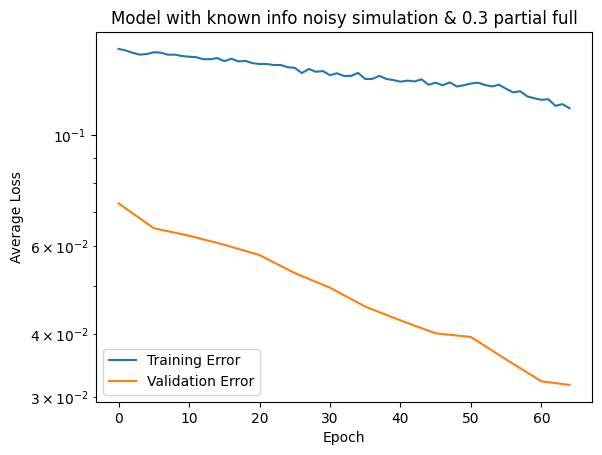

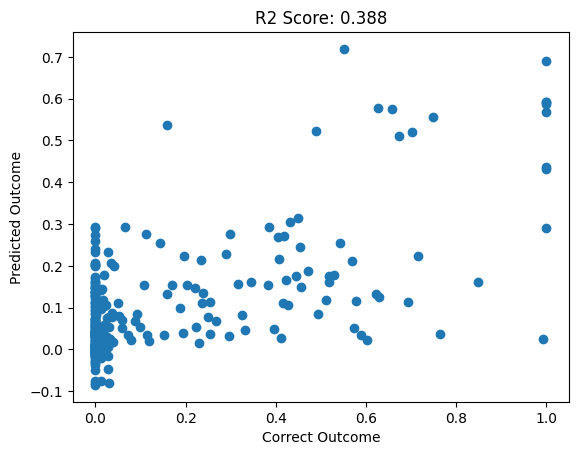

0.3876748160712876
0.27774449078783503


In [33]:
use_info = "known info noisy simulation"
DATA_NOISE_PERC = 0.4  #How much data will have noise
NOISE_MAXRANGE  = 0.6  #The range around the mean 
NOISE_MINRANGE  = 0.4

end_epochs_nd = 10
num_epochs = 55 + end_epochs_nd
r_state = 0
AM = AlgoModulators(DO, lr = 0.001, eps_value = 0.25, min_samples_ratio = 0.20, use_context = False)
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu", use_case = "noise detection")
DO.simulate_noise(DATA_NOISE_PERC, NOISE_MINRANGE, NOISE_MAXRANGE)
dataloader = DO.prep_dataloader(use_info, batch_size)    
model = initialize_model(DO, dataloader, hidden_size, r_state, dropout = 0.05) 
TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, r_state, results_path, select_gradients = select_gradients,
                             end_epochs_noise_detection = end_epochs_nd, best_valid_error = np.inf)
TVM.train_model(DO, AM, model, final_analysis = True)
#INSPECT.save_train_val_logs(DO, AM, TVM, model, final_analysis = False, noise_profile = noise_profile)

visualize_train_val_error(DO, TVM)
INSPECT.validation_scatter_r2(DO, TVM, model)
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


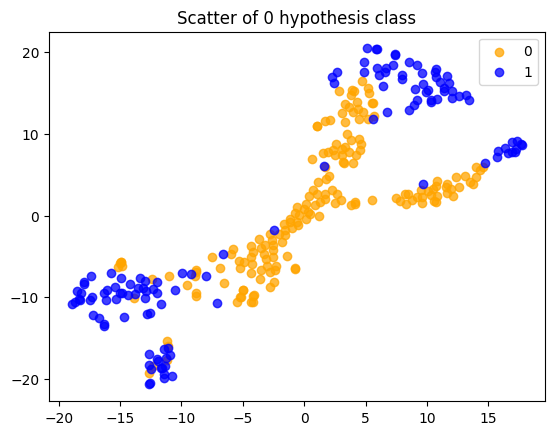

Accuracy: 0.8896321070234113
Precision: 0.8823529411764706


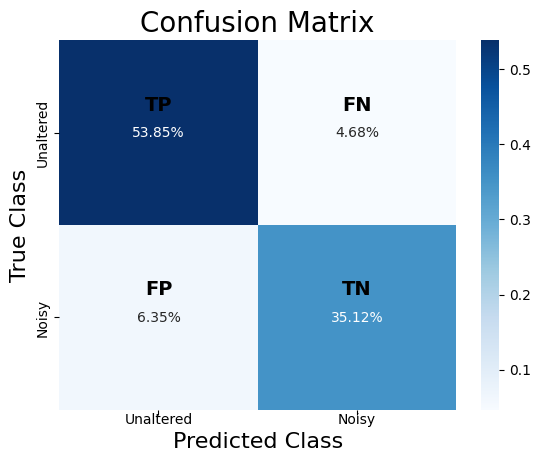

In [34]:
array_grads_context, do_hyp_class = get_gradarrays_n_labels(DO, 0, layer = -2, remov_avg = False, include_context = False, normalize_grads_context=False, 
                                                            loss_in_context = False, only_loss_context = False, num_batches = 1, use_case = "noise_detection")

dbscan = DBSCAN(eps=0.25, min_samples=int(batch_size*0.20)).fit(array_grads_context) 
pred_labels = dbscan.labels_
pred_labels = pred_labels*-1

_, _, true_labels = cluster_and_visualize(array_grads_context, 0, true_labels = do_hyp_class["label"].values, option_3D = False)

print(f"Accuracy: {accuracy_score(true_labels, pred_labels)}")
print(f"Precision: {precision_score(true_labels, pred_labels)}")

plot_confusion_matrix(true_labels, pred_labels)